importing Jupyter notebook from radio_environment.ipynb
Generate radio environment......


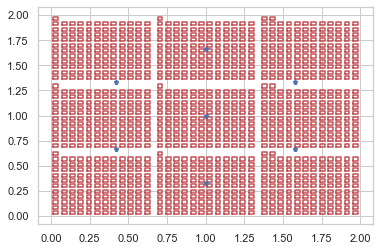

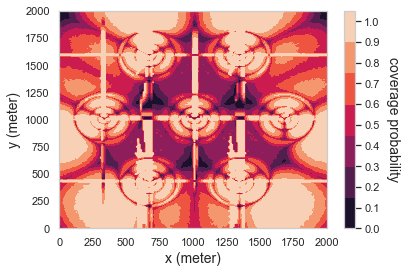

importing Jupyter notebook from radio_mapping.ipynb


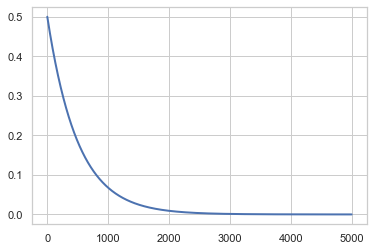

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 512)               1536      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 66    

AttributeError: module 'tensorflow' has no attribute 'set_random_seed'

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Nov. 7
Modified on Nov. 25, 2019
@author: Yong Zeng

For cellular-connected UAV, implement simultaneous navigation and radio mapping (SNARM) via
deep reinforcement learning (DRL)
"""
%matplotlib inline
import import_ipynb
import numpy as np
from keras.callbacks import TensorBoard
import tensorflow as tf
from collections import deque
import time
import random
from keras.layers import Input, Dense,Lambda
from keras.models import Model
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from numpy import linalg as LA
import keras.backend as K


import radio_environment as rad_env #the actual radio environment
from radio_mapping import RadioMap  #the radio map class



X_MAX=2000.0 
Y_MAX=2000.0 #The area region in meters
MAX_VALS=np.array([[X_MAX,Y_MAX]])

DESTINATION=np.array([[1400,1600]],dtype="float32")#UAV flying destination in meter
DIST_TOLERANCE=30#considered as reach destination if UAV reaches the vicinity within DIST_TOLERANCE meters

DISCOUNT = 1
REPLAY_MEMORY_SIZE = 100_000  # How many last steps to keep for model training
MIN_REPLAY_MEMORY_SIZE = 5_000  # Minimum number of steps in a memory to start training
MINIBATCH_SIZE = 32  # How many steps (samples) to use for training
UPDATE_TARGET_EVERY = 5  # Terminal states (end of episodes)
MAX_STEP=200 #maximum number of time steps per episode
MODEL_NAME = '512_256_128_128'
MIN_REWARD = -1000  # For model save
nSTEP=30 #parameter for multi-step learning

# Environment settings
EPISODES = 5000#Number of training episodes


# Exploration settings
epsilon =0.5  # not a constant, going to be decayed
EPSILON_DECAY = 0.998
MIN_EPSILON = 0

episode_all=np.arange(EPISODES)
epsilon_all=epsilon*EPSILON_DECAY**episode_all
epsilon_all=np.maximum(epsilon_all,MIN_EPSILON)

plt.figure()
plt.plot(episode_all,epsilon_all,'b',linewidth=2)
plt.grid(True,which='major',axis='both')
plt.show()

#  Stats settings
AGGREGATE_STATS_EVERY = 50  # episodes
SHOW_PREVIEW = False


delta_t=0.5 #time step length in seconds

#penalty measured in terms of the time required to reach destination
REACH_DES_REWARD=200
MOVE_PENALTY = 1
NON_COVER_PENALTY = 40
OUT_BOUND_PENALTY = 10000


x=np.linspace(0,X_MAX,200)
y=np.linspace(0,Y_MAX,200)


OBSERVATION_SPACE_VALUES=(2,)#2-dimensional UAV flight, x-y coordinate of UAV
ACTIONS=np.array([[0, 1],
             [1,0],
             [0,-1],
             [-1,0]],dtype=int)#the possible actions (UAV flying directions)   
ACTION_SPACE_SIZE = ACTIONS.shape[0]
   
MAX_SPEED=20 #maximum UAV speed in m/s
STEP_DISPLACEMENT=MAX_SPEED*delta_t #The displacement per time step

  
# Create models folder
if not os.path.isdir('models'):
    os.makedirs('models')


# Own Tensorboard class
class ModifiedTensorBoard(TensorBoard):

    # Overriding init to set initial step and writer (we want one log file for all .fit() calls)
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.step = 1
        self.writer = tf.summary.FileWriter(self.log_dir)

    # Overriding this method to stop creating default log writer
    def set_model(self, model):
        pass

    # Overrided, saves logs with our step number
    # (otherwise every .fit() will start writing from 0th step)
    def on_epoch_end(self, epoch, logs=None):
        self.update_stats(**logs)

    # Overrided
    # We train for one batch only, no need to save anything at epoch end
    def on_batch_end(self, batch, logs=None):
        pass

    # Overrided, so won't close writer
    def on_train_end(self, _):
        pass

    # Custom method for saving own metrics
    # Creates writer, writes custom metrics and closes writer
    def update_stats(self, **stats):
        self._write_logs(stats, self.step)


class UAVEnv:
    
    def reset(self):
        self.episode_step = 0
        s0=self.random_generate_states(num_states=1)
         
        return s0


    def random_generate_states(self,num_states):
        loc_x=np.random.uniform(50,X_MAX-50,(num_states,1))
        loc_y=np.random.uniform(50,Y_MAX-50,(num_states,1))
        loc=np.concatenate((loc_x,loc_y),axis=1)
        
        return loc
            

   #for each location visited by the UAV, it will have the J signal measurements from
   #each of the M cellular BSs
    #based on these M*J measurements, calculate the empirical outage probability
    def get_empirical_outage(self, location):
        #location given in meters
        #convert the location to kilometer
        loc_km=np.zeros(shape=(1,3))
        loc_km[0,:2]=location/1000
        loc_km[0,2]=0.1
        Pout=rad_env.getPointMiniOutage(loc_km)
              
        return Pout[0]
    
  
    
    def step(self, current_state, action_idx, cur_traj):#the actual step
        self.episode_step += 1
                      
        next_state=current_state+STEP_DISPLACEMENT*ACTIONS[action_idx]
        outbound=False
        out_bound_check1=next_state<0
        out_bound_check2=next_state[0,0]>X_MAX
        out_bound_check3=next_state[0,1]>Y_MAX
        if out_bound_check1.any() or out_bound_check2.any() or out_bound_check3.any():
            outbound=True       
            next_state[next_state<0]=0
            next_state[0,0]=np.minimum(X_MAX,next_state[0,0])
            next_state[0,1]=np.minimum(Y_MAX,next_state[0,1])
           
        if LA.norm(next_state-DESTINATION)<=DIST_TOLERANCE:
            terminal=True
            print('Reach destination====================================================================================!!!!!!!!')
        else:
            terminal=False
    
        if terminal or outbound:
            reward=-MOVE_PENALTY
        else: 
            Pout=self.get_empirical_outage(next_state)
            reward=-MOVE_PENALTY-NON_COVER_PENALTY*Pout

            Pout=np.array(Pout)
            Pout=Pout.reshape((-1,1))
            new_row=np.concatenate((next_state,Pout),axis=1)
            radio_map.add_new_measured_data(new_row)#store the measured data to the database of radio map
            
                          
        done = False
                               
        if terminal or self.episode_step >= MAX_STEP or outbound:
            done = True
                           
        return next_state, reward, terminal,outbound,done
    
    
    
    def simulated_step(self,current_state, action_idx, cur_traj):
        #the simulated step: the UAV does not actually take the fly, but use the
        #radio map to have a simulated step              
        self.episode_step+=1
                     
        next_state=current_state+STEP_DISPLACEMENT*ACTIONS[action_idx]
        outbound=False
        out_bound_check1=next_state<0
        out_bound_check2=next_state[0,0]>X_MAX
        out_bound_check3=next_state[0,1]>Y_MAX
        if out_bound_check1.any() or out_bound_check2.any() or out_bound_check3.any():
            outbound=True       
            next_state[next_state<0]=0
            next_state[0,0]=np.minimum(X_MAX,next_state[0,0])
            next_state[0,1]=np.minimum(Y_MAX,next_state[0,1])
           
        if LA.norm(next_state-DESTINATION)<=DIST_TOLERANCE:
            terminal=True
            print('Simulated: Reach destination================================================================================!!!!!!!!')
        else:
            terminal=False
    
        if terminal or outbound:
            reward=-MOVE_PENALTY
        else:#This part makes a difference between the actual step and the simulated step
            Pout=radio_map.predict_outage_prob(next_state)#The outage probability is predicted based on the radio map, instead of being measured
            reward=-MOVE_PENALTY-NON_COVER_PENALTY*Pout[0]

                          
        done = False
                               
        if terminal or self.episode_step >= MAX_STEP or outbound:
            done = True
                           
        return next_state, reward, terminal,outbound,done
    
            

env = UAVEnv()
sim_env=UAVEnv()#Simulated UAV environment 
radio_map=RadioMap(X_MAX,Y_MAX)    


# For more repetitive results
random.seed(1)
np.random.seed(1)
tf.set_random_seed(1)


# Agent class
class DQNAgent:
    def __init__(self):
        # Main model
        
        self.model = self.create_model(dueling=True)
        
        self.initilize_model()

        # Target network
        self.target_model = self.create_model(dueling=True)
        self.target_model.set_weights(self.model.get_weights())

        self.replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)

        # Custom tensorboard object
        self.tensorboard = ModifiedTensorBoard(log_dir="logs/{}-{}".format(MODEL_NAME, int(time.time())))

        # Used to count when to update target network with main network's weights
        self.target_update_counter = 0

    def create_model(self, dueling):
        inp = Input(shape=OBSERVATION_SPACE_VALUES)
        outp=Dense(512,activation='relu')(inp)
        outp=Dense(256,activation='relu')(outp)
        outp=Dense(128,activation='relu')(outp)
        outp=Dense(128,activation='relu')(outp)
        
        if(dueling):
            # Have the network estimate the Advantage function as an intermediate layer
            outp=Dense(ACTION_SPACE_SIZE+1, activation='linear')(outp)
            outp=Lambda(lambda i: K.expand_dims(i[:,0],-1) + i[:,1:] - K.mean(i[:,1:], keepdims=True), output_shape=(ACTION_SPACE_SIZE,))(outp)
        else:
            outp=Dense(ACTION_SPACE_SIZE,activation='linear')(outp)
            
        model=Model(inp,outp)
        
        model.compile(optimizer='adam',loss='mean_squared_error',metrics=['mean_absolute_error', 'mean_squared_error'])
        model.summary()
        return model


       
    def normalize_data(self,input_data):        
        return input_data/MAX_VALS

       
    def initilize_model(self):       
        #initialize the DQN so that the Q values of each (state,action) pair
        #equal to: -MOVE_PENALTY*distance/STEP_DISPLACEMENT,
        #where distance is the distance between the next state and the destination
        #this will encourage shortest path flying initially when there is no information on the coverage map
               
        xx,yy=np.meshgrid(x,y,indexing='ij')
        
        plt.figure(0)
        plt.plot(DESTINATION[0,0],DESTINATION[0,1],'r>',markersize=15)
        plt.show()
                
        num_states=100_000
        xy_loc=env.random_generate_states(num_states)
        
        
        Actions_aug=np.zeros((1,xy_loc.shape[1],ACTION_SPACE_SIZE),dtype=int)
        for i in range(Actions_aug.shape[2]):
            Actions_aug[:,:,i]=ACTIONS[i]
            
        Actions_aug=np.tile(Actions_aug,(xy_loc.shape[0],1,1))
        xy_loc_aug=np.zeros((xy_loc.shape[0],xy_loc.shape[1],1))
        xy_loc_aug[:,:,0]=xy_loc
        xy_loc_aug=np.repeat(xy_loc_aug,ACTION_SPACE_SIZE,axis=2)
        xy_loc_next_state=xy_loc_aug+STEP_DISPLACEMENT*Actions_aug
        
        xy_loc_next_state[xy_loc_next_state<0]=0
        xy_loc_next_state[:,0,:]=np.minimum(X_MAX,xy_loc_next_state[:,0,:])
        xy_loc_next_state[:,1,:]=np.minimum(Y_MAX,xy_loc_next_state[:,1,:])
        
        end_loc_reshaped=np.zeros((1,2,1))
        end_loc_reshaped[0,:,0]=DESTINATION
        distance_to_destination=LA.norm(xy_loc_next_state-end_loc_reshaped,axis=1)#compute the distance to destination            
        Q_init=-distance_to_destination/STEP_DISPLACEMENT*MOVE_PENALTY
        
                
        train_data=xy_loc[:int(num_states*0.8),:]
        train_label=Q_init[:int(num_states*0.8),:]
             
        test_data=xy_loc[int(num_states*0.8):,:]
        test_label=Q_init[int(num_states*0.8):,:]
        
       
        history=self.model.fit(self.normalize_data(train_data),train_label,epochs=20,validation_split=0.2,verbose=1)
                    
        history_dict = history.history
        history_dict.keys()
                                                                
        mse = history_dict['mean_squared_error']
        val_mse = history_dict['val_mean_squared_error']
        mae = history_dict['mean_absolute_error']
        val_mae=history_dict['val_mean_absolute_error']
        
     
        epochs = range(1, len(mse) + 1)
        
        plt.figure()   
        
        plt.plot(epochs, mse, 'bo', label='Training MSE')
        plt.plot(epochs, val_mse, 'r', label='Validation MSE')
        plt.title('Training and validation MSE')
#        plt.ylim(0,100)
        plt.xlabel('Epochs')
        plt.ylabel('MSE')
        plt.legend()
        
        plt.show()
        
        
        plt.figure()   # clear figure
        
        plt.plot(epochs, mae, 'bo', label='Training MAE')
        plt.plot(epochs, val_mae, 'r', label='Validation MAE')
        plt.title('Training and validation accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('MAE')
    #    plt.ylim(0,15)
        plt.legend()
        
        plt.show()
             
        result=self.model.evaluate(self.normalize_data(test_data),test_label)
        print(result)
                        
    
 
    #Add data to replay memory for n-step return
    #(St, At, R_nstep, S_{t+n}, terminal, outbound, done)
    #where R_nstep=R_{t+1}+gamma*R_{t+2}+gamma^2*R_{t+3}....+gamma^(nSTEP-1)*R_{t+n}
    def update_replay_memory_nStepLearning(self,slide_window,nSTEP,endEpisode):
        #update only after n steps
        if len(slide_window)<nSTEP:
            return

#        slide_window contains the list in the following order:
#        (current_state,action_idx,reward,next_state,terminal,outbound,done)        
        rewards_nsteps= [transition[2] for transition in slide_window]
        discount_nsteps=DISCOUNT**np.arange(nSTEP)
        R_nstep=sum(rewards_nsteps*discount_nsteps)
        
        St=slide_window[0][0]
        At=slide_window[0][1]
        
        St_plus_n=slide_window[-1][3]
        terminal=slide_window[-1][4]
        outbound=slide_window[-1][5]
        done=slide_window[-1][6]
        
        """ Store experience in memory buffer
        """         
        self.replay_memory.append((St,At,R_nstep,St_plus_n,terminal,outbound,done))
        
             
        if endEpisode:#Truncated n-step return for the last few steps at the end of the episode 
            for i in range(1,nSTEP):
                rewards_i=rewards_nsteps[i:]
                discount_i=DISCOUNT**np.arange(nSTEP-i)
                R_i=sum(rewards_i*discount_i)
                
                St_i=slide_window[i][0]
                At_i=slide_window[i][1]
                              
                self.replay_memory.append((St_i,At_i,R_i,St_plus_n,terminal,outbound,done))
            
        
    def sample_batch_from_replay_memory(self):
        minibatch = random.sample(self.replay_memory, MINIBATCH_SIZE)
        current_state_batch = np.zeros((MINIBATCH_SIZE, OBSERVATION_SPACE_VALUES[0]))
        next_state_batch = np.zeros((MINIBATCH_SIZE, OBSERVATION_SPACE_VALUES[0]))
        
        actions_idx, rewards, terminal, outbound, done= [], [], [],[],[]
                
        for idx, val in enumerate(minibatch):     
            current_state_batch[idx] = val[0]
            actions_idx.append(val[1])
            rewards.append(val[2])
            next_state_batch[idx] = val[3]           
            terminal.append(val[4])
            outbound.append(val[5])
            done.append(val[6])
            
        return current_state_batch, actions_idx, rewards, next_state_batch, terminal, outbound, done

  
    
    def deepDoubleQlearn(self,episode_done):
        # Start training only if certain number of samples is already saved                 
        if len(self.replay_memory) < MIN_REPLAY_MEMORY_SIZE:
            return
                                
        current_state_batch, actions_idx, rewards, next_state_batch, terminal,outbound, done = self.sample_batch_from_replay_memory()
                    
        
        current_Q_values=self.model.predict(self.normalize_data(current_state_batch))
       
        next_Q_values_currentNetwork=self.model.predict(self.normalize_data(next_state_batch))  # use the current network to evaluate action
        next_actions=np.argmax(next_Q_values_currentNetwork,axis=1)        
          
        next_Q_values = self.target_model.predict(self.normalize_data(next_state_batch))  # still use the target network to evaluate value
        

        Y=current_Q_values
        
        for i in range(MINIBATCH_SIZE):
       
            if terminal[i]:
                target = rewards[i]+REACH_DES_REWARD
            elif outbound[i]:
                target=rewards[i]-OUT_BOUND_PENALTY
            else:
                target = rewards[i] + DISCOUNT**nSTEP*next_Q_values[i,next_actions[i]]
                        
            Y[i,actions_idx[i]]=target
            
     
                   
        self.model.fit(self.normalize_data(current_state_batch), Y, batch_size=MINIBATCH_SIZE,verbose=0, shuffle=False, callbacks=[self.tensorboard] if episode_done else None)
        
        
        # Update target network counter every episode
        if episode_done:
            self.target_update_counter += 1            
            # If counter reaches set value, update target network with weights of main network
            if self.target_update_counter >= UPDATE_TARGET_EVERY:
                self.target_model.set_weights(self.model.get_weights())
                self.target_update_counter = 0
                      
   
    def choose_action(self,current_state,cur_traj,epsilon):                       
        next_possible_states=current_state+STEP_DISPLACEMENT*ACTIONS       
        
        next_possible_states[next_possible_states<0]=0
        next_possible_states[:,0]=np.minimum(next_possible_states[:,0],X_MAX)
        next_possible_states[:,1]=np.minimum(next_possible_states[:,1],Y_MAX)        
        
        next_possible_states=next_possible_states.tolist()
        
        no_repetition=[]
        
        cur_traj=cur_traj[-10:] #no return to the previous few locations
        
        for state in next_possible_states:
            no_repetition.append(state not in cur_traj)
             
        
        actions_idx_all=np.arange(ACTION_SPACE_SIZE)
        actions_idx_valid=actions_idx_all[no_repetition]
           
        if np.random.rand()<=epsilon or len(actions_idx_valid)==0:#Exploration
            action_idx=np.random.randint(0,ACTION_SPACE_SIZE) 
            return action_idx
        else:        
            Q_value=self.model.predict(self.normalize_data(current_state))
            Q_value=Q_value[0]            
            action_idx_maxVal=np.argmax(Q_value)
            if action_idx_maxVal in actions_idx_valid:
                action_idx=action_idx_maxVal
            else:
                action_idx=random.sample(actions_idx_valid.tolist(),1)
                action_idx=action_idx[0]                                                         
            return action_idx
        


agent = DQNAgent()

ep_rewards,ep_trajecotry,ep_reach_terminal,ep_outbound,ep_actions=[],[],[],[],[]
ep_MSE,ep_MAE,ep_Max_Absolute_Error,ep_bin_cross_entr=[],[],[],[]
ep_sim_rewards,ep_sim_trajecotry,ep_sim_reach_terminal,ep_sim_outbound,ep_sim_actions=[],[],[],[],[]

# Iterate over episodes
for episode in tqdm(range(1, EPISODES + 1), ascii=True, unit='episodes'):

    # Update tensorboard step every episode
    agent.tensorboard.step = episode

    # Restarting episode - reset episode reward and step number
    episode_reward = 0
    episode_sim_reward = 0

    # Reset environment and get initial state
    current_state = env.reset()
    cur_trajectory=[]
#    cur_trajectory=np.array([]).reshape(0,OBSERVATION_SPACE_VALUES[0])
    cur_actions=[]   
    slide_window=deque(maxlen=nSTEP)
    # Reset flag and start iterating until episode ends   
    done=False
    
    
    #The starting state of the simulated trajectory
#    sim_current_state=env.random_generate_states(num_states=1)
    sim_current_state=sim_env.reset()
    sim_cur_trajectory=[]
    sim_slide_window=deque(maxlen=nSTEP)
    sim_done=False

    sim_step_per_act_step=int(np.floor(episode/100))#Number of simulation steps performed per actual step
    sim_step_per_act_step=np.minimum(sim_step_per_act_step,10)
    
    
    
    while not done:
        #The actual UAV flight
        cur_trajectory.append(np.squeeze(current_state).tolist())
        action_idx=agent.choose_action(current_state,cur_trajectory,epsilon)
             
        #actual step and measurement
        next_state, reward, terminal, outbound, done = env.step(current_state,action_idx,cur_trajectory)
        
        radio_map.update_radio_map(verbose_on=0)
        
        
        episode_reward += reward        
        slide_window.append((current_state,action_idx,reward,next_state,terminal,outbound,done)) 

        agent.update_replay_memory_nStepLearning(slide_window,nSTEP,done)  
        agent.deepDoubleQlearn(done)
        current_state = next_state
        
        #The simulated trajectory
        for temp_counter in range(sim_step_per_act_step):
            sim_cur_trajectory.append(np.squeeze(sim_current_state).tolist())
            sim_action_idx=agent.choose_action(sim_current_state,sim_cur_trajectory,epsilon)
            sim_next_state, sim_reward, sim_terminal, sim_outbound, sim_done =sim_env.simulated_step(sim_current_state,sim_action_idx,sim_cur_trajectory)
            episode_sim_reward+=sim_reward
            sim_slide_window.append((sim_current_state,sim_action_idx,sim_reward,sim_next_state,sim_terminal,sim_outbound,sim_done))
            agent.update_replay_memory_nStepLearning(sim_slide_window,nSTEP,sim_done)
            agent.deepDoubleQlearn(sim_done)
            sim_current_state = sim_next_state
            if sim_done:#start a new episode if the simulation trajectory completes one episode
                ep_sim_rewards.append(episode_sim_reward)
                ep_sim_trajecotry.append(sim_cur_trajectory)
                ep_sim_reach_terminal.append(sim_terminal)
                ep_sim_outbound.append(sim_outbound)
                
                episode_sim_reward = 0
                sim_current_state=sim_env.reset()
                sim_cur_trajectory=[]
                sim_slide_window=deque(maxlen=nSTEP)
                sim_done=False
                
                

                   
    MSE,MAE,Max_Absolute_Error,bin_cross_entr=radio_map.check_radio_map_acc()
    ep_MSE.append(MSE)
#    print('ep_MSE:', ep_MSE)
    ep_MAE.append(MAE)
#    print('ep_MAE:', ep_MAE)
    ep_Max_Absolute_Error.append(Max_Absolute_Error)
#    print('ep_Max_Absolute_Error:', ep_Max_Absolute_Error)
    ep_bin_cross_entr.append(bin_cross_entr)
#    print('bin_cross_entr:', ep_bin_cross_entr)
    
    
    
    # Append episode reward to a list and log stats (every given number of episodes)
    ep_rewards.append(episode_reward)
    ep_trajecotry.append(cur_trajectory)
    ep_reach_terminal.append(terminal)
    ep_outbound.append(outbound)
#    ep_actions.append(cur_actions)
    
   
    
    if episode%10 == 0:
#        dist_to_dest=LA.norm(start_loc-end_loc)
#        print("Start location:{}, distance to destination:{}".format(start_loc,dist_to_dest))
        print("Episode: {}, total steps: {},  final return: {}".format(episode,len(cur_trajectory),episode_reward))
        
    if not episode % AGGREGATE_STATS_EVERY or episode == 1:
        average_reward = sum(ep_rewards[-AGGREGATE_STATS_EVERY:])/len(ep_rewards[-AGGREGATE_STATS_EVERY:])
        min_reward = min(ep_rewards[-AGGREGATE_STATS_EVERY:])
        max_reward = max(ep_rewards[-AGGREGATE_STATS_EVERY:])
        agent.tensorboard.update_stats(reward_avg=average_reward, reward_min=min_reward, reward_max=max_reward, epsilon=epsilon)

        # Save model, but only when min reward is greater or equal a set value
        if min_reward >= MIN_REWARD:
            agent.model.save(f'models/{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}.model')

    # Decay epsilon
    if epsilon > MIN_EPSILON:
        epsilon *= EPSILON_DECAY
        epsilon = max(MIN_EPSILON, epsilon)
        
        



fig=plt.figure(60)
plt.plot(np.arange(len(ep_MSE))+1,ep_MSE,'b-',linewidth=2)
plt.grid(which='major', axis='both')
plt.xlabel('Episode')
plt.ylabel('MSE')
fig.savefig('MSE.eps')
fig.savefig('MSE.pdf')
fig.savefig('MSE.jpg')

fig=plt.figure(70)
plt.plot(np.arange(len(ep_MAE))+1,ep_MAE,'b-',linewidth=2)
plt.grid(which='major', axis='both')
plt.xlabel('Episode')
plt.ylabel('MAE')
fig.savefig('MAE.eps')
fig.savefig('MAE.pdf')
fig.savefig('MAE.jpg')

fig=plt.figure(80)
plt.plot(np.arange(len(ep_Max_Absolute_Error))+1,ep_Max_Absolute_Error,'b-',linewidth=2)
plt.grid(which='major', axis='both')
plt.xlabel('Episode')
plt.ylabel('Maximum absolute eror')
fig.savefig('Max_Absolute_Error.eps')
fig.savefig('Max_Absolute_Error.pdf')
fig.savefig('Max_Absolute_Error.jpg')

fig=plt.figure(90)
plt.plot(np.arange(len(ep_bin_cross_entr))+1,ep_bin_cross_entr,'b-',linewidth=2)
plt.grid(which='major', axis='both')
plt.xlabel('Episode')
plt.ylabel('Binary cross entropy')
fig.savefig('Bin_cross_entr.eps')
fig.savefig('Bin_cross_entr.pdf')
fig.savefig('Bin_cross_entr.jpg')
    
   

def get_moving_average(mylist,N):
    cumsum, moving_aves = [0], []
    for i, x in enumerate(mylist, 1):
        cumsum.append(cumsum[i-1] + x)

        if i>=N:
            moving_ave = (cumsum[i] - cumsum[i-N])/N
            moving_aves.append(moving_ave)
    return moving_aves
        

    

fig=plt.figure()
plt.xlabel('Episode',fontsize=14)
plt.ylabel('Return per episode',fontsize=14,labelpad=-2)
N=200
return_mov_avg=get_moving_average(ep_rewards,N)
plt.plot(np.arange(len(return_mov_avg))+N,return_mov_avg,'r-',linewidth=5)
#plt.ylim(-6000,0)
fig.savefig('return.eps')
fig.savefig('return.pdf')
fig.savefig('return.jpg')



##============VIew the learned radio map for given height
UAV_height=0.1 # UAV height in km
step=101 #include the start point at 0 and end point, the space between two sample points is D/(step-1)
D=2
X_vec=range(D*(step-1)+1)
Y_vec=range(D*(step-1)+1)
numX,numY=np.size(X_vec),np.size(Y_vec)

OutageMapLearned=np.zeros(shape=(numX,numY))
#Loc_All=np.zeros(shape=(0,3))
for i in range(numX):
    Loc_cur=np.zeros(shape=(numY,2))
    Loc_cur[:,0]=X_vec[i]/step
    Loc_cur[:,1]=np.array(Y_vec)/step
    Loc_cur=Loc_cur*1000 #convert to meter
    OutageMapLearned[i,:]=radio_map.predict_outage_prob(Loc_cur)
#    Loc_cur[:,2]=UAV_height
#    Loc_All=np.concatenate((Loc_All,Loc_cur),axis=0)
    


fig=plt.figure(20)
#plt.style.use('classic')
plt.contourf(np.array(X_vec)*10,np.array(Y_vec)*10,1-OutageMapLearned)
v = np.linspace(0, 1.0, 11, endpoint=True)
cbar=plt.colorbar(ticks=v) 
cbar.set_label('coverage probability',labelpad=20, rotation=270,fontsize=14)
plt.xlabel('x (meter)',fontsize=14)
plt.ylabel('y (meter)',fontsize=14)
plt.show()
fig.savefig('CoverageMapLearned.eps')
fig.savefig('CoverageMapLearned.pdf')
fig.savefig('CoverageMapLearned.jpg')
          
    


npzfile = np.load('radioenvir.npz')
OutageMapActual=npzfile['arr_0']
X_vec=npzfile['arr_1']
Y_vec=npzfile['arr_2']


fig=plt.figure(30)
#xx,yy=np.meshgrid(x,y,indexing='ij')
#plt.contourf(xx,yy,coverage_map)

plt.contourf(np.array(X_vec)*10,np.array(Y_vec)*10,1-OutageMapActual)
v = np.linspace(0, 1.0, 11, endpoint=True)
cbar=plt.colorbar(ticks=v) 


#v = np.linspace(0, 1.0, 11, endpoint=True)
#cbar=plt.colorbar(ticks=v)
#cbar.ax.set_yticklabels(['0','0.2','0.4','0.6','0.8','1.0'])
cbar.set_label('coverage probability',labelpad=20, rotation=270,fontsize=14)


for episode_idx in range(episode-200, episode):
    S_seq=ep_trajecotry[episode_idx]
    S_seq=np.squeeze(np.asarray(S_seq))
    

    if S_seq.ndim>1:
        plt.plot(S_seq[0,0],S_seq[0,1],'rx',markersize=5)
        plt.plot(S_seq[:,0],S_seq[:,1],'-')
    else:
        plt.plot(S_seq[0],S_seq[1],'rx',markersize=5)
        plt.plot(S_seq[0],S_seq[1],'-')
        
        
    plt.plot(DESTINATION[0,0],DESTINATION[0,1],'b^',markersize=25)


plt.plot(DESTINATION[0,0],DESTINATION[0,1],'b^',markersize=25)
plt.xlabel('x (meter)',fontsize=14)
plt.ylabel('y (meter)',fontsize=14)
plt.show()
fig.savefig('trajectoriesSNARM.eps')
fig.savefig('trajectoriesSNARM.pdf')
fig.savefig('trajectoriesSNARM.jpg')

print('{}/{} episodes reach terminal'.format(ep_reach_terminal.count(True),episode))


#Save the simulation ressult
np.savez('SNARM_main_Results',return_mov_avg,ep_rewards,ep_trajecotry) 